In [1]:
!git clone http://github.com/am1tyadav/superhero

Cloning into 'superhero'...
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 8 (delta 0), reused 4 (delta 0), pack-reused 0
Receiving objects: 100% (8/8), 47.08 KiB | 679.00 KiB/s, done.


In [2]:
with open('superhero/superheroes.txt', 'r') as f:
  data=f.read()

data[:100]

'jumpa\t\ndoctor fate\t\nstarlight\t\nisildur\t\nlasher\t\nvarvara\t\nthe target\t\naxel\t\nbattra\t\nchangeling\t\npyrrh'

In [3]:
import tensorflow as tf
print(tf.__version__)

2.13.0


In [4]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~',
    split='\n'
)

In [5]:
tokenizer.fit_on_texts(data)

In [6]:
char_to_index=tokenizer.word_index
index_to_char=dict((v,k) for k, v in char_to_index.items())

print(index_to_char)

{1: '\t', 2: 'a', 3: 'e', 4: 'r', 5: 'o', 6: 'n', 7: 'i', 8: ' ', 9: 't', 10: 's', 11: 'l', 12: 'm', 13: 'h', 14: 'd', 15: 'c', 16: 'u', 17: 'g', 18: 'k', 19: 'b', 20: 'p', 21: 'y', 22: 'w', 23: 'f', 24: 'v', 25: 'j', 26: 'z', 27: 'x', 28: 'q'}


#Task 3

In [7]:
names=data.splitlines()
names[:10]

['jumpa\t',
 'doctor fate\t',
 'starlight\t',
 'isildur\t',
 'lasher\t',
 'varvara\t',
 'the target\t',
 'axel\t',
 'battra\t',
 'changeling\t']

In [8]:
tokenizer.texts_to_sequences(names[0])

[[25], [16], [12], [20], [2], [1]]

In [9]:
def name_to_seq(name):
  return[tokenizer.texts_to_sequences(c)[0][0] for c in name]

In [10]:
name_to_seq(names[0])

[25, 16, 12, 20, 2, 1]

In [11]:
def seq_to_name(seq):
  return ''.join([index_to_char[i] for i in seq if i !=0])

In [12]:
seq_to_name(name_to_seq(names[0]))

'jumpa\t'

#TASK 4

In [13]:
sequences= []

for name in names:
  seq=name_to_seq(name)
  if len(seq) >=2:
    sequences += [seq[:i] for i in range(2, len(seq)+1)]

In [14]:
sequences[:10]

[[25, 16],
 [25, 16, 12],
 [25, 16, 12, 20],
 [25, 16, 12, 20, 2],
 [25, 16, 12, 20, 2, 1],
 [14, 5],
 [14, 5, 15],
 [14, 5, 15, 9],
 [14, 5, 15, 9, 5],
 [14, 5, 15, 9, 5, 4]]

In [15]:
max_len=max([len(x) for x in sequences])
print(max_len)

33


In [16]:
padded_sequences=tf.keras.preprocessing.sequence.pad_sequences(
    sequences, padding='pre',
    maxlen=max_len
)

print(padded_sequences[0])

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0 25 16]


In [17]:
padded_sequences.shape

(88279, 33)

#TASK 5

In [18]:
x, y=padded_sequences[:, :-1], padded_sequences[:, -1]
print(x.shape, y.shape)

(88279, 32) (88279,)


In [19]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y)  # default split is 30%

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)



(66209, 32) (66209,)
(22070, 32) (22070,)


In [20]:
num_chars=len(char_to_index.keys()) +1   #1 is bcz we added 0 to our vocabulary
print(num_chars)

29


#TASK 6

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPool1D, LSTM
from tensorflow.keras.layers import Bidirectional, Dense


model= Sequential([
                  Embedding(num_chars, 8, input_length=max_len-1),
                  Conv1D(64, 5, strides=1, activation='tanh', padding='causal'),
                  MaxPool1D(2),
                  LSTM(32),
                  Dense(num_chars, activation='softmax')

])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 32, 8)             232       
                                                                 
 conv1d (Conv1D)             (None, 32, 64)            2624      
                                                                 
 max_pooling1d (MaxPooling1  (None, 16, 64)            0         
 D)                                                              
                                                                 
 lstm (LSTM)                 (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 29)                957       
                                                                 
Total params: 16229 (63.39 KB)
Trainable params: 16229 (63.39 KB)
Non-trainable params: 0 (0.00 Byte)
____________________

# Task 7

In [22]:
h=model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=50, verbose=2,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
    ]
)

Epoch 1/50
2070/2070 - 26s - loss: 2.7410 - accuracy: 0.1885 - val_loss: 2.5752 - val_accuracy: 0.2286 - 26s/epoch - 12ms/step
Epoch 2/50
2070/2070 - 12s - loss: 2.5419 - accuracy: 0.2400 - val_loss: 2.4972 - val_accuracy: 0.2493 - 12s/epoch - 6ms/step
Epoch 3/50
2070/2070 - 12s - loss: 2.4803 - accuracy: 0.2541 - val_loss: 2.4525 - val_accuracy: 0.2565 - 12s/epoch - 6ms/step
Epoch 4/50
2070/2070 - 13s - loss: 2.4356 - accuracy: 0.2677 - val_loss: 2.4141 - val_accuracy: 0.2686 - 13s/epoch - 6ms/step
Epoch 5/50
2070/2070 - 12s - loss: 2.3991 - accuracy: 0.2750 - val_loss: 2.3878 - val_accuracy: 0.2735 - 12s/epoch - 6ms/step
Epoch 6/50
2070/2070 - 13s - loss: 2.3686 - accuracy: 0.2828 - val_loss: 2.3678 - val_accuracy: 0.2772 - 13s/epoch - 6ms/step
Epoch 7/50
2070/2070 - 13s - loss: 2.3424 - accuracy: 0.2894 - val_loss: 2.3504 - val_accuracy: 0.2861 - 13s/epoch - 6ms/step
Epoch 8/50
2070/2070 - 12s - loss: 2.3184 - accuracy: 0.2963 - val_loss: 2.3311 - val_accuracy: 0.2917 - 12s/epoch - 

In [23]:
from matplotlib import pyplot as plt

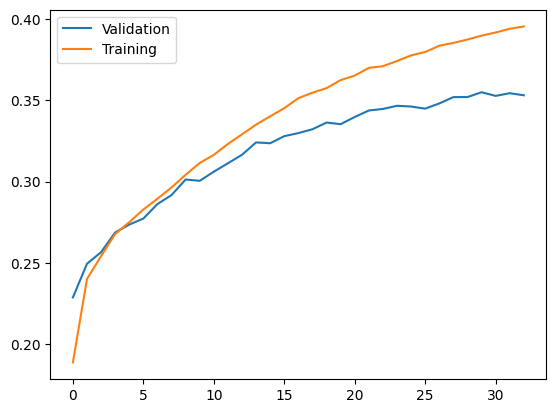

In [25]:
epochs_ran=len(h.history['loss'])
plt.plot(range(0, epochs_ran), h.history['val_accuracy'], label='Validation')
plt.plot(range(0, epochs_ran), h.history['accuracy'], label='Training')
plt.legend()
plt.show()

# Task 8

In [27]:
def generate_names(seed):
  for i in range(0, 40):
    seq=name_to_seq(seed)
    padded=tf.keras.preprocessing.sequence.pad_sequences([seq], padding='pre',
                                                         maxlen=max_len-1,
                                                         truncating='pre')

    pred=model.predict(padded)[0]
    pred_char= index_to_char[tf.argmax(pred).numpy()]
    seed+=pred_char

    if pred_char=='\t':
      break
  print(seed)


In [28]:
generate_names('a')

1/1 [==============================] - 0s 30ms/step
arter stranger	


In [29]:
generate_names('po')

1/1 [==============================] - 0s 19ms/step
poldie shera	


In [30]:
generate_names('f')

1/1 [==============================] - 0s 18ms/step
flash	
